In [3]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score
import pylab as plt
%matplotlib inline

In [4]:
data_fname = '../datasets/data_2020-12-06.csv'
last_date = data_fname.split('/')[-1][:-4].split('_')[-1]
print(f'last date = {last_date}')
df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')

last date = 2020-12-06


In [5]:
steps_=['case0', 'case1', 'case2', 'case3', 'case4', 'case5',
       'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12',
       'case13', 'case14', 'case15', 'case16', 'case17', 'case18', 'case19',
       'case20', 'case21', 'case22', 'case23', 'case24', 'case25', 'case26',
       'case27', 'case28', 'case29', 'case30', 'case31', 'case32', 'case33',
       'case34', 'case35', 'death0', 'death1', 'death2', 'death3', 'death4',
       'death5', 'death6', 'death7', 'death8', 'death9', 'death10', 'death11',
       'death12', 'death13', 'death14', 'death15', 'death16', 'death17',
       'death18', 'death19', 'death20', 'death21', 'death22', 'death23',
       'death24', 'death25', 'death26', 'death27', 'death28', 'death29',
       'death30', 'death31', 'death32', 'death33', 'death34', 'death35',
       'total_case', 'total_death']

In [6]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,11.0,16.0,45.0,48.0,60.0,48.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,34.0,36.0,40.0,45.0,30.0,34.0,42.0,19.0,12.0,29.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,3.0,7.0,8.0,16.0,9.0,14.0,24.0,27.0,47.0,41.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,7.0,4.0,7.0,7.0,15.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,12.0,3.0,9.0,12.0,6.0,5.0,2.0,3.0,13.0,11.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


In [7]:
cov_prefix = 'perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop'

df_z['pcy'] = df.case0/df.case0.sum()

In [48]:
cur = steps_[0]

Y='pcy'
formula = f'{Y}~{cov}'

model = smf.glm(
    formula=formula,
    data=df_z,
    family=sm.families.Poisson(sm.families.links.log())
).fit()

#model = smf.glm(
#    formula=formula,
#    data=df_z,
#    family=sm.families.Gaussian(sm.families.links.log())
#).fit()



print(f'{model.summary()}\n\n')

prd = model.predict()
cor = pd.DataFrame(
    data={'prd': prd, 'grd': df_z[cur].values}, 
    index=df.index).corr().loc['prd', 'grd']

df_z[cur + '_glm'] = model.predict()
 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pcy   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6.4292
Date:                Sun, 12 Feb 2023   Deviance:                       1.8988
Time:                        16:12:33   Pearson chi2:                     4.34
No. Iterations:                     8   Pseudo R-squ. (CS):           0.001322
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -11.6883      5.431     -2.

In [49]:
model.aic

28.858338164238294

In [50]:
prd

array([3.98898571e-05, 3.14484018e-05, 1.31612894e-05, ...,
       1.94631282e-05, 6.18063628e-05, 8.27159610e-06])

In [51]:
cor

0.5011413285846736

In [39]:
a=df_z[['case0','case0_glm']]
a=(a-a.mean())/a.std()
af=a
af.max()

case0        26.090144
case0_glm    31.872088
dtype: float64

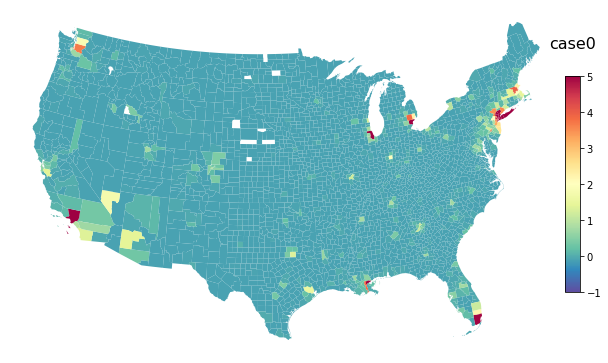

In [40]:
import geopandas as gd
import matplotlib.colors as colors
fig = plt.figure(figsize=[10,15])
ax=plt.gca()
variable='case0'
cbax = fig.add_axes([0.9, 0.4, 0.02, 0.2])   
cbax.set_title(str(variable),fontsize=16,y=1.1)

#cax = divider.append_axes("right", size="5%", pad=0.1)
usa = gd.read_file('../datasets/usmap/cb_2018_us_county_5m.shp')
usa['fips']=[x+y for (x,y) in zip(usa.STATEFP.values,usa.COUNTYFP.values)]
usa=usa.set_index('fips')

DF=usa.join(af)
DF = DF[~DF.STATEFP.isin(['02', '15'])]
DF=DF.to_crs('epsg:4326')
DF=DF.to_crs("EPSG:2163")
DF.plot(column=variable,ax=ax,cmap='Spectral_r',norm=colors.Normalize(vmin=-1, vmax=5), cax=cbax, legend=True)
#ax.set_visible('off');
ax.axis('off');

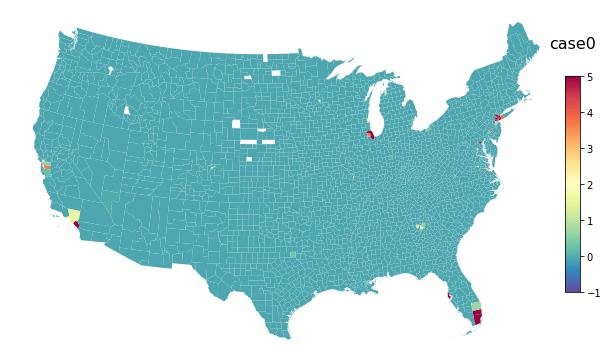

In [45]:
fig = plt.figure(figsize=[10,15])
ax=plt.gca()
variable='case0'
cbax = fig.add_axes([0.9, 0.4, 0.02, 0.2])   
cbax.set_title(str(variable),fontsize=16,y=1.1)

DF.plot(column=variable+'_glm',ax=ax,cmap='Spectral_r',norm=colors.Normalize(vmin=-1, vmax=5), cax=cbax, legend=True)
ax.axis('off');

In [52]:
case_next = df.case1/df.case1.sum()
df_z_test= df_z.copy()
df_z_test['case0']=case_next 

model.predict(df_z_test)


fips
01001    3.988986e-05
01003    3.144840e-05
01005    1.316129e-05
01007    3.641531e-06
01009    2.625604e-07
             ...     
56037    5.071428e-04
56039    4.881481e-05
56041    1.946313e-05
56043    6.180636e-05
56045    8.271596e-06
Length: 3094, dtype: float64